## Kelebek🦋Sınıflandırma

In [80]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import cv2

import os,random
from collections import Counter
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from tensorflow.keras import regularizers

from PIL import Image
from tensorflow.keras.applications.resnet50 import preprocess_input



os.environ["KERAS_BACKEND"] = "tensorflow"

import keras

# from IPython.display import Image, display

import warnings
warnings.filterwarnings('ignore')

base_dir = "/kaggle/input/butterfly-image-classification"


In [81]:
df = pd.read_csv("/kaggle/input/butterfly-image-classification/Training_set.csv")

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

image_dir = "/kaggle/input/butterfly-image-classification/train"

train_datagen = ImageDataGenerator(
    rescale=1./255,   #preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,          # yatay çevirme
    vertical_flip=False,           # dikey çevirme
    brightness_range=(0.7, 1.3),   # parlaklık
    channel_shift_range=15.0,
    fill_mode='reflect',           # fill-doldurma
    preprocessing_function=None     # transfer learning için preprocess_input ver
)#preprocessing_function=preprocess_input kullanılırsa rescale=1./255'i kaldır veya preprocess'in beklentisini kontrol et

val_datagen = ImageDataGenerator(rescale=1./255)
#val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(32, 32),
    batch_size=32,
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


# Sınıf Dağılımı ve Örnek Görseller

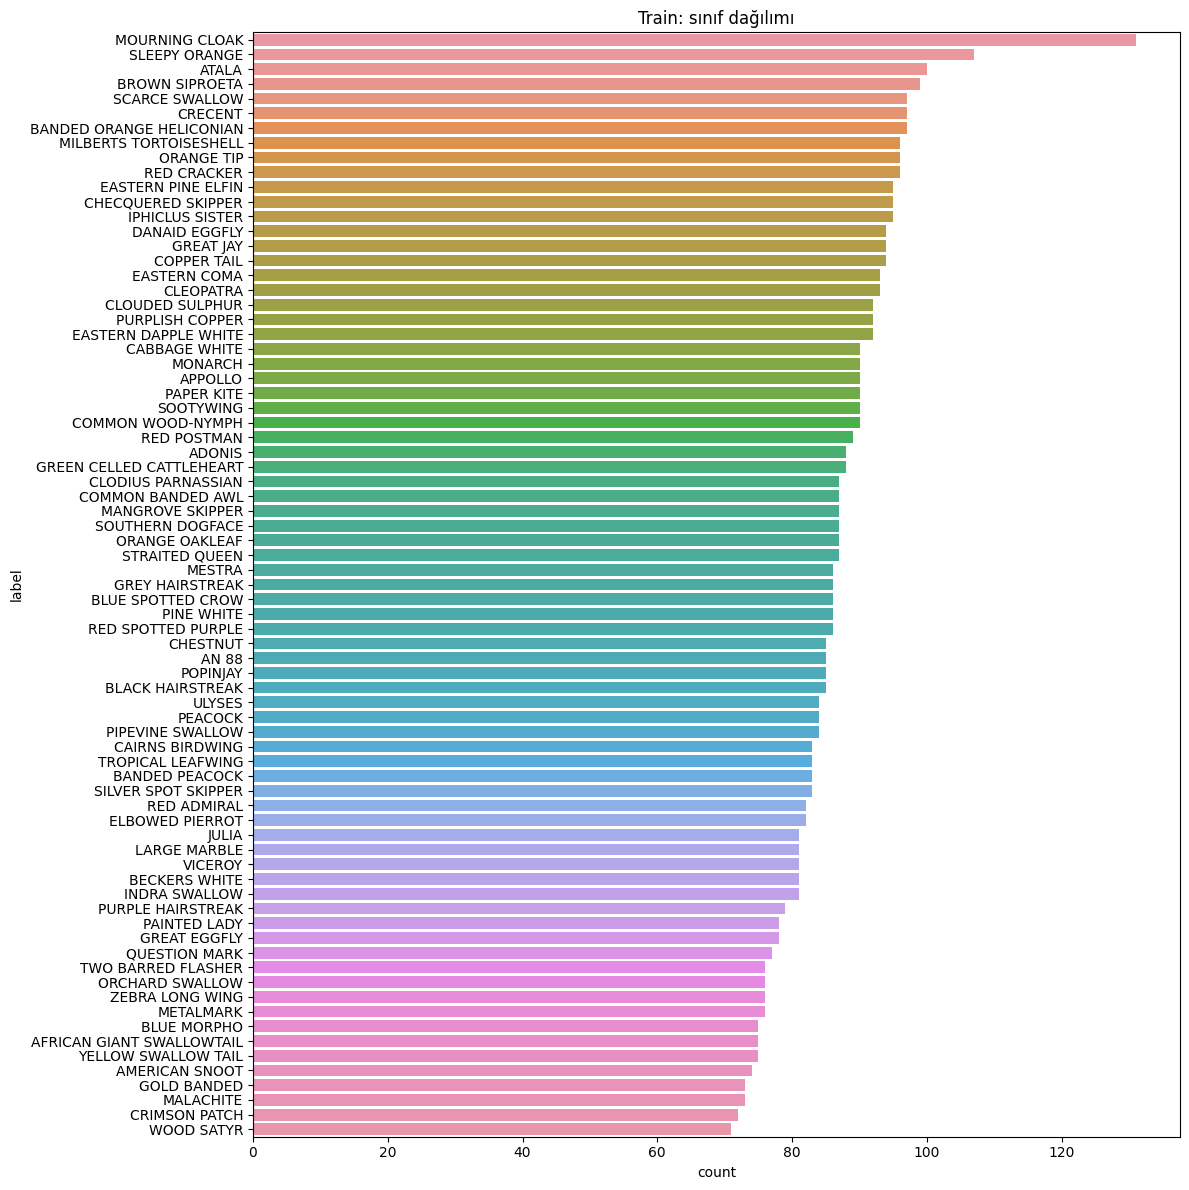

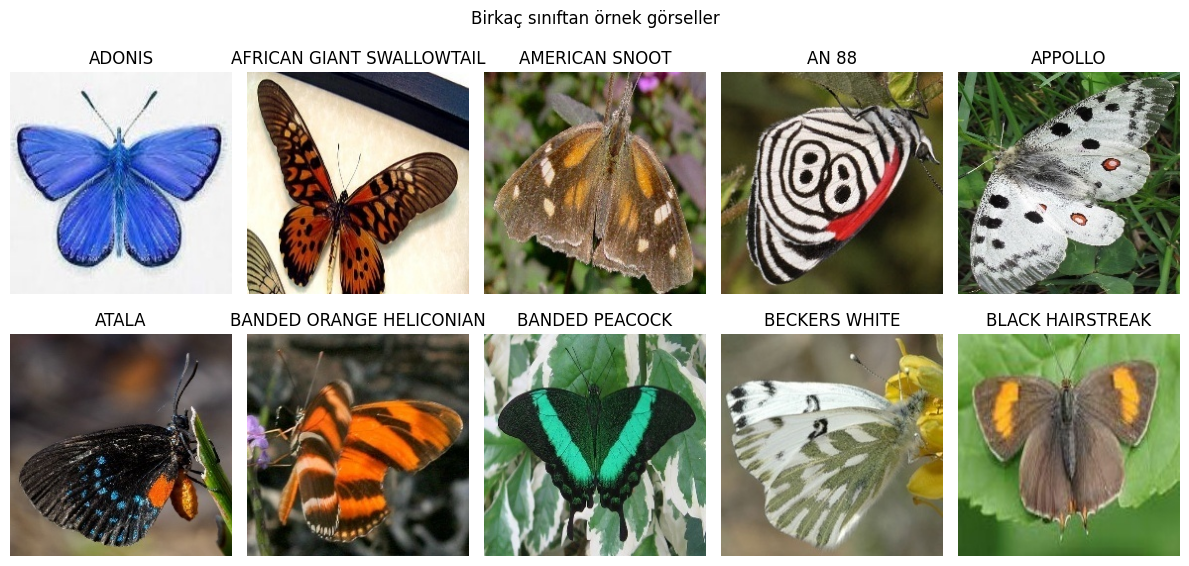

In [82]:
# Kısa önizleme: sınıf dağılımı + örnek görseller

BASE = "/kaggle/input/butterfly-image-classification"
train = pd.read_csv(os.path.join(BASE, "Training_set.csv"))
train["path"] = train["filename"].apply(lambda f: os.path.join(BASE, "train", f))

# 1) sınıf dağılımı
plt.figure(figsize=(12,12))
sns.countplot(y="label", data=train, order=train['label'].value_counts().index)
plt.title("Train: sınıf dağılımı"); plt.tight_layout(); plt.show()

# 2) Sınıflardan örnekler
classes = sorted(train['label'].unique())[:10]#X sınıf göster
plt.figure(figsize=(12,6))
for i,c in enumerate(classes,1):
    sample = train[train.label==c].sample(1, random_state=42).iloc[0]
    img = Image.open(sample.path).convert("RGB").resize((224,224))
    ax = plt.subplot(2, (len(classes)+1)//2, i); ax.imshow(img); ax.set_title(c); ax.axis('off')
plt.suptitle("Birkaç sınıftan örnek görseller"); plt.tight_layout(); plt.show()


# Model Eğitimi

In [83]:

# activations = {#Kullanılabilir aktivasyon fonksiyonları
#     'Sigmoid': tf.keras.activations.sigmoid(x),
#     'Tanh': tf.keras.activations.tanh(x),
#     'ReLU': tf.keras.activations.relu(x),
#     'Leaky ReLU': tf.keras.layers.LeakyReLU(alpha=0.1)(x).numpy(),
#     'ELU': tf.keras.activations.elu(x),
#     'Swish': tf.keras.activations.swish(x)
# }

# sınıf miktarı
num_classes = len(train_generator.class_indices)

tf.keras.backend.clear_session()   # önceki modeli temizle
input_shape = train_generator.image_shape  #shape=(128,128,3)

#model tanımlama katmanlama
model = models.Sequential([
    layers.Input(input_shape),              # generator target_size ile uyumlu

    #32: Kullanılacak filtre (feature map) sayısı. Daha fazla filtre = daha fazla özellik öğrenme kapasitesi.
    #(3, 3),3: Filtre boyutu. 3x3'lük küçük pencereler ile görsel taranır.
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2),

    layers.Conv2D(64, 3, activation='relu'),
    #MaxPooling2D: Özellik haritasının boyutunu küçültür, hesaplama maliyetini düşürür.
    #(2, 2): 2x2 pencerede en yüksek değeri alarak boyutu yarıya indirir (ör: 150x150 → 75x75).
    layers.MaxPooling2D(2),

    
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2),#İkinci havuzlama ile tekrar küçült.
    layers.Dropout(0.3),#0.x: (%x0) olasılıkla nöronlar kapatılır. Overfitting'i azaltmak için kulanılır

    
    layers.Flatten(),#Çok boyutlu veriyi tek boyutlu vektöre çevirir (ör: 4x4x128 → 2048). Dense katmanına aktarım için zorunludur.
    layers.Dense(256, activation='relu'),#parametre1(256)->Nöron sayısı. Yüksek değer = karmaşık ilişkileri öğrenme kapasitesi. activation='relu': Hızlı öğrenme ve non-linearity sağlar.
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')#Parametre1 -> SınıfSayısı(bu veri setinde 75), activation='softmax': Olasılık dağılımı üretir (toplamı 1 olacak şekilde).
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),#Optimizer, Modelin ağırlıklarını güncelleme stratejisi.
    loss='categorical_crossentropy',#Çok sınıflı sınıflandırmada kullanılan kayıp fonksiyonu. Gerçek ve tahmin edilen dağılım arasındaki farkı ölçer.
    metrics=['accuracy']#Takip metriği
)

es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)#Gerekli durumlarda işlemi erken sonlandır
#monitor='val_loss' -> Takip edilen metrik; burada validation_loss izleniyor.
#patience=x -> Eğer x epoch boyunca iyileşme olmazsa eğitim durur.
#restore_best_weights=True -> Eğitim durduğunda en iyi model ağırlıkları geri yüklenir.

mc = callbacks.ModelCheckpoint('best_baseline.h5', monitor='val_loss', save_best_only=True)#Modeli her epoch sonunda kaydeder. En düşük loss değerinde model saklanır.

history = model.fit(
    train_generator,
    validation_data=val_generator,#Her epoch sonunda modelin doğruluğunu ve kaybını kontrol et.
    epochs=30, #Maksimum eğitim sayısı. EarlyStopping ile genellikle erken durabilir.
    callbacks=[es, mc]
)

# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=40,
#     validation_data=val_generator,
#     validation_steps=val_generator.samples // val_generator.batch_size
# )




Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - accuracy: 0.0208 - loss: 4.2650 - val_accuracy: 0.0469 - val_loss: 4.0110
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.0788 - loss: 3.6471 - val_accuracy: 0.0938 - val_loss: 3.6617
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 104ms/step - accuracy: 0.1440 - loss: 3.3163 - val_accuracy: 0.1646 - val_loss: 3.1758
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 106ms/step - accuracy: 0.2048 - loss: 2.9774 - val_accuracy: 0.2385 - val_loss: 2.8562
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - accuracy: 0.2496 - loss: 2.7594 - val_accuracy: 0.2054 - val_loss: 3.1646
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - accuracy: 0.3024 - loss: 2.5166 - val_accuracy: 0.2262 - val_loss: 2.9866
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.3255 - loss: 2.4569 - val_accuracy: 0.2446 - val_loss: 3.0198
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.3513 - loss: 2

# Değerlendirme metrikleri

# Accuracy&Loss Veri Grafikleri

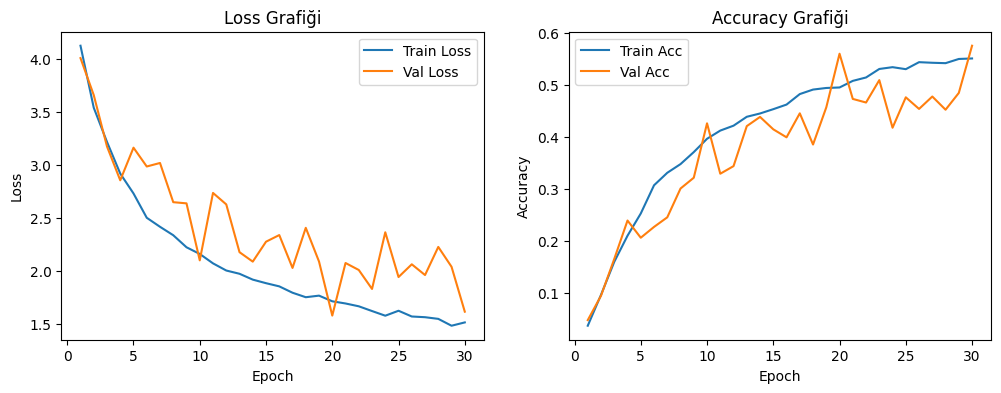

In [84]:
# Eğitim grafikleri
h = history.history
epochs = range(1, len(h['loss'])+1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, h['loss'], label='Train Loss')
plt.plot(epochs, h['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Grafiği')

plt.subplot(1,2,2)
plt.plot(epochs, h['accuracy'], label='Train Acc')
plt.plot(epochs, h['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.title('Accuracy Grafiği')

plt.show()


# Confusion Matrix & Classification Report

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step


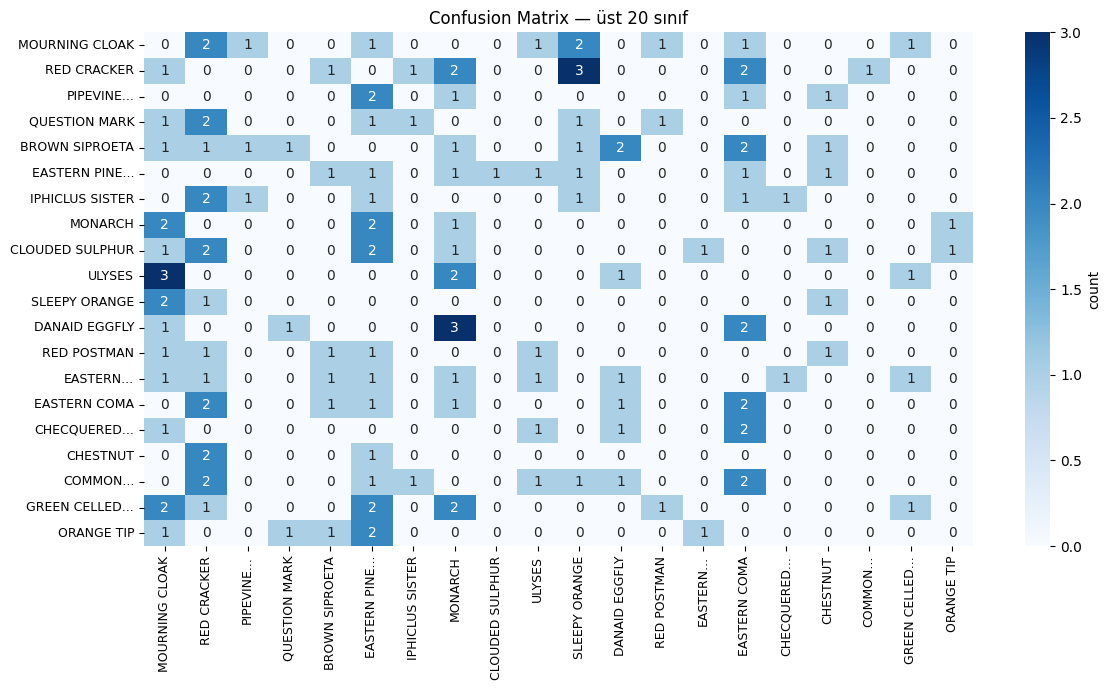

,precision,recall,f1-score,support
MOURNING CLOAK,0.000,0.000,0.000,35.0
RED CRACKER,0.000,0.000,0.000,27.0
PIPEVINE SWALLOW,0.000,0.000,0.000,26.0
QUESTION MARK,0.000,0.000,0.000,26.0
BROWN SIPROETA,0.000,0.000,0.000,26.0
IPHICLUS SISTER,0.000,0.000,0.000,24.0
ULYSES,0.000,0.000,0.000,22.0
CLOUDED SULPHUR,0.000,0.000,0.000,23.0
RED POSTMAN,0.000,0.000,0.000,21.0
EASTERN DAPPLE WHITE,0.000,0.000,0.000,21.0


In [85]:
import math, numpy as np, pandas as pd, textwrap

# predict (steps int olmalı)
steps = int(math.ceil(val_generator.samples / val_generator.batch_size))
preds = model.predict(val_generator, steps=steps, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_generator.classes
labels = list(val_generator.class_indices.keys())

# classification report -> df
cr_df = pd.DataFrame(classification_report(y_true, y_pred, target_names=labels, output_dict=True)).T.loc[labels]

# hangi sınıfları gösterelim? (ör: top_k by support)
top_k = min(20, len(labels))                # gösterilecek sınıf sayısını değiştir
top_labels = cr_df['support'].sort_values(ascending=False).head(top_k).index.tolist()
idx = [labels.index(l) for l in top_labels]

# alt-confusion matrix ve kısaltılmış etiketler
cm = confusion_matrix(y_true, y_pred)
cm_sub = cm[np.ix_(idx, idx)]
short_labels = [textwrap.shorten(l, width=15, placeholder='...') for l in top_labels]

plt.figure(figsize=(max(10, len(short_labels)*0.6), max(6, len(short_labels)*0.35)))
sns.heatmap(cm_sub, annot=True, fmt='d', cmap='Blues',
            xticklabels=short_labels, yticklabels=short_labels, cbar_kws={'label':'count'})
plt.xticks(rotation=90, fontsize=9); plt.yticks(fontsize=9)
plt.title(f'Confusion Matrix — üst {top_k} sınıf'); plt.tight_layout(); plt.show()

# 5) o sınıfların classification report'unu göster (daha okunaklı tablo)
display(cr_df.loc[top_labels].sort_values('f1-score').round(3))


# Grad-CAM

In [104]:
import tensorflow as tf, numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_prep(path, img_size, preprocess_fn):
    img = load_img(path, target_size=img_size)
    arr = img_to_array(img)
    proc = preprocess_fn(np.copy(arr))
    return img, np.expand_dims(proc, 0)

def gradcam_by_forward(img_tensor_np, model, last_conv_name, eps=1e-8):
    """
    img_tensor_np: numpy array shape (1,H,W,3)
    """
    # 1) convert numpy -> tf.Tensor (float32)
    img_tensor = tf.convert_to_tensor(img_tensor_np, dtype=tf.float32)

    # 2) forward under tape, capture conv outputs by name
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        x = img_tensor
        conv_outputs = None
        for layer in model.layers:
            x = layer(x)
            if layer.name == last_conv_name:
                conv_outputs = x
        preds = x

        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # 3) gradients and pooled grads
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / (tf.reduce_max(heatmap) + eps)
    return heatmap.numpy()

# === Kısa kullanım ===
# 1) img yükle ve hazırla (senin preprocess_input ve img_size kullan)
path = os.path.join(image_dir, 'Image_50.jpg')   # veya val_generator.filenames[0]
orig, x_proc_np = load_and_prep(path, img_size, preprocess_input)  # x_proc_np is numpy

# 2) doğrula last_conv_name gerçekten var mı?
print([L.name for L in model.layers])   # tüm layer isimlerini gör
# örn last_conv_name = 'conv2d_2' olarak kullanmadan önce listede olduğundan emin ol

# 3) gradcam çalıştır (numpy -> tf conversion artık yapılıyor inside)
heatmap = gradcam_by_forward(x_proc_np, model, last_conv_name='conv2d_2')

# 4) overlay ve göster (önceki overlay fonksiyonunu kullan)
ov = overlay_heatmap(orig, heatmap, alpha=0.4)
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(orig); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(ov); plt.axis('off')
plt.show()


['conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 'conv2d_2', 'max_pooling2d_2', 'dropout', 'flatten', 'dense', 'dropout_1', 'dense_1']


ValueError: Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 512, but received input with shape (1, 156800)

xx

In [106]:
# Kısa: Xception parametrelerini kullanarak Grad-CAM
import os, random, numpy as np, matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

img_dir = os.path.join(base_dir, "test", "Image_50.jpg")

# --- Buraya senin verdiğin parametreler ---
from tensorflow import keras
model_builder = model
img_size = (128, 128)
preprocess_input = lambda x: x/255.0
decode_predictions = {v:k for k,v in val_generator.class_indices.items()}  # ImageNet head?

# --- helper: son Conv2D katmanını bul ---
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise RuntimeError("No Conv2D layer found")
last_conv_name = "conv2d_2"

# --- Grad-CAM hesap ---
def make_gradcam_heatmap(img_tensor, model, last_conv_name, eps=1e-8):
    grad_model = tf.keras.models.Model([model.inputs],
                                      [model.get_layer(last_conv_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_tensor)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + eps)
    return heatmap.numpy()

# --- Görüntü yükle + preprocess, predict için hazırla ---
def load_and_preprocess(path):
    img = load_img(path, target_size=img_size)
    x = img_to_array(img)            # HxWx3
    x_proc = preprocess_input(x)     # **kritik**: burada eğitimde kullanılan preprocess ile aynı olmalı
    return img, np.expand_dims(x_proc, axis=0)

# --- overlay için basit fonksiyon (matplotlib fallback) ---
def overlay(img_pil, heatmap, alpha=0.4):
    import matplotlib.cm as cm
    img_arr = img_to_array(img_pil).astype('float32')/255.0
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (img_arr.shape[0], img_arr.shape[1])).numpy().squeeze()
    colored = cm.get_cmap('jet')(heatmap_resized)[:,:,:3]  # 0-1
    overlay = img_arr*(1-alpha) + colored*alpha
    overlay = np.clip(overlay, 0, 1)
    return np.uint8(255*overlay)

# --- Kullanım örneği: bir val örneği seç, Grad-CAM uygula, göster ---
# Not: val_generator.filenames ve image_dir tanımlı olmalı
last_conv = find_last_conv_layer(model)
print("Last conv layer:", last_conv)

# warm-up (gerekirse)
try:
    _ = model.predict(next(iter(val_generator))[0:1])
except Exception:
    try:
        _ = model.predict(val_generator, steps=1, verbose=0)
    except Exception:
        pass

# seçilecek örnekler
filenames = val_generator.filenames
sample = random.choice(filenames)
path = os.path.join(image_dir, sample)

orig_img, x_proc = load_and_preprocess(path)             # img_size kullanıldı, preprocess uygulandı
heatmap = make_gradcam_heatmap(x_proc, model, last_conv)  # şekil: (h,w)
overlay_img = overlay(orig_img, heatmap)

# Prediction: eğer model ImageNet head ile ise decode_predictions kullan; aksi halde kendi class mapping'ini kullan
preds = model.predict(x_proc)
if preds.shape[-1] == 1000:
    print("Top ImageNet preds:", decode_predictions(preds, top=3)[0])
else:
    # kendi label mapping'in varsa:
    if hasattr(val_generator, 'class_indices'):
        inv = {v:k for k,v in val_generator.class_indices.items()}
        top_idx = preds.argmax()
        print("Pred:", inv[top_idx], "prob:", preds.max())

# göster
plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.imshow(orig_img); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(overlay_img); plt.title("Grad-CAM"); plt.axis('off')
plt.show()


Last conv layer: conv2d_2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


AttributeError: The layer sequential has never been called and thus has no defined output.

**Aşağıdaki kod bellek kontrolu için bırakılmıştır**

In [107]:
# 1. History objesi var mı? (model.fit sonucu)
print("history var mı?", 'history' in globals())
if 'history' in globals():
    print(history.history.keys())
    # örnek: print(history.history['loss'][:3])

# 2. model var mı?
print("model var mı?", 'model' in globals())

# 3. val_generator özellikleri
print("val_generator var mı?", 'val_generator' in globals())
if 'val_generator' in globals():
    print("samples:", getattr(val_generator, 'samples', None))
    print("batch_size:", getattr(val_generator, 'batch_size', None))
    print("classes attr var mı?:", hasattr(val_generator, 'classes'))
    print("filenames attr var mı?:", hasattr(val_generator, 'filenames'))
    # kaç adım gerektiği:
    import math
    steps = math.ceil(val_generator.samples / val_generator.batch_size)
    print("expected steps for predict/evaluate:", steps)


history var mı? True
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])
model var mı? True
val_generator var mı? True
samples: 1300
batch_size: 32
classes attr var mı?: True
filenames attr var mı?: True
expected steps for predict/evaluate: 41
